In [1]:
SUBMISSION = True
USE_RESCUER_CV = not SUBMISSION
LB = not SUBMISSION
SEED = 209321206
VERBOSE = 1

# Imports

In [2]:
import pandas as pd
START_TIME = pd.datetime.now()

import gc
import glob
import os
import re
import sys
import ujson as json

from copy import deepcopy
from functools import partial

import cv2
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

from catboost import CatBoostRegressor

from IPython.core.display import display
from joblib import Parallel,delayed

from keras.models import Model
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Input, Dense
from keras.callbacks import EarlyStopping

from lightgbm import LGBMRegressor,LGBMClassifier,plot_importance

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,SnowballStemmer

from xgboost import XGBRegressor,XGBClassifier # Not used

from scipy.stats import mode
from scipy import sparse

from sklearn.base import BaseEstimator,RegressorMixin,TransformerMixin
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.ensemble import BaggingRegressor,ExtraTreesRegressor
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,BayesianRidge,LassoCV,RidgeCV
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import StratifiedKFold,train_test_split,GroupKFold
from sklearn.pipeline import FeatureUnion,make_union,make_pipeline,_fit_transform_one,_transform_one
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.utils.multiclass import unique_labels

from tqdm import tqdm_notebook

Using TensorFlow backend.


In [3]:
import logging
from logging import StreamHandler

class KaggleHandler(StreamHandler):
    
    def __init__(self):
        StreamHandler.__init__(self)
        
    def emit(self, record):
        msg_fmt = re.sub(r'[^0-9A-z\.\,\-\:\=]', ' ', str(self.format(record)))
        secs_passed = (pd.datetime.now() - START_TIME).seconds
        msg = '[%ss] %s' % (secs_passed, msg_fmt)
        os.system(f'echo {msg}')
        sys.stdout.write(msg + '\n')
        
logger = logging.getLogger(__name__)
logger.handlers = []
logger.setLevel(logging.DEBUG)
fmt = logging.Formatter('[%(asctime)s]: %(message)s')
kh = KaggleHandler()
kh.setFormatter(fmt)
logger.addHandler(kh)

In [4]:
logger.info('Seed set to %d' % SEED)
np.random.seed(SEED)

[5s] [2019-03-26 17:34:57,428]: Seed set to 209321206


In [5]:
logger.info(os.listdir("../input"))

[5s] [2019-03-26 17:34:57,447]: [ malaysian-state-data ,  model-weights ,  petfinder-adoption-prediction ]


In [6]:
logger.info(f'SUBMISSION={SUBMISSION}, USE_RESCUER_CV={USE_RESCUER_CV}, LB={LB}, VERBOSE={VERBOSE}')

[5s] [2019-03-26 17:34:57,466]: SUBMISSION=True, USE_RESCUER_CV=False, LB=False, VERBOSE=1


# Helper functions

In [7]:
def qwk(predicted_ratings, actual_ratings, nb_ratings=5):
    """Calculate quadratic weighted kappa."""
    assert len(actual_ratings) == len(predicted_ratings) #"Both the vectors should be of same length
    actual_ratings = actual_ratings.astype(np.int64)
    predicted_ratings = predicted_ratings.astype(np.int64)

    # 1. Get the confusion matrix 
    conf_mtx = confusion_matrix(actual_ratings, predicted_ratings).astype(np.float64)

    # 2. Create a weight matrix
    weight_mtx = np.zeros((nb_ratings, nb_ratings))
    for i in range(nb_ratings):
        for j in range(nb_ratings):
            weight_mtx[i][j] = (i-j)**2 / ((nb_ratings-1)**2)

    # 3.Get the histograms for both the raters
    actual_ratings_hist = np.bincount(actual_ratings,minlength=nb_ratings)
    predicted_ratings_hist = np.bincount(predicted_ratings, minlength=nb_ratings)

    # 4. Perform an outer product of the histograms
    out_prod = np.outer(actual_ratings_hist, predicted_ratings_hist).astype(np.float64)

    # 5. Normalize both- the confusion matrix and the outer product matrix
    conf_mtx /= conf_mtx.sum()
    out_prod /= out_prod.sum()

    # Calculate the weighted kappa
    numerator = (conf_mtx * weight_mtx).sum()
    denominator = (out_prod * weight_mtx).sum()
    score = (1 -(numerator/denominator))
    return score

In [8]:
def get_rescuer_ids(df):
    """Return RescuerID indices and count."""
    rescuer_ids = (df.reset_index(drop=True).reset_index().groupby(['RescuerID']).agg({
        'index': {'unique': lambda x: x.unique().tolist(), 'count': lambda x: x.nunique()},
        'AdoptionSpeed': {'mean': lambda x: x.mean()}
    }))
    rescuer_ids.columns = rescuer_ids.columns.droplevel(0)
    rescuer_ids['bucket'] = (
        #pd.cut(rescuer_ids['mean'], bins=[-1,1,1.5,2,2.5,3,5]).cat.codes.astype(str) +
        '1' +
        pd.cut(rescuer_ids['count'], bins=[-1,2,4,10000]).cat.codes.astype(str)
    )
    rescuer_ids['count'] = rescuer_ids['bucket']
    return rescuer_ids

In [9]:
def find_nearest(array, value):
    """Find the nearest value from given array."""
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def labelize_match_target(y_pred, y_train):
    """Match target distributions."""
    pdf_train = np.bincount(y_train)
    pdf_train = pdf_train / pdf_train.sum()
    cdf_train = np.cumsum(pdf_train)
    
    counts,bins = np.histogram(y_pred, bins=4000000)
    cdf_pred = np.cumsum(counts / counts.sum())
    #print(y_train,y_pred)
    cutoffs = []
    for cutpoint in cdf_train:
        cutoff_idx = find_nearest(cdf_pred, cutpoint)
        cutoff = bins[cutoff_idx]
        cutoffs.append(cutoff)
    cutoffs[-1] = 4
    if VERBOSE:
        logger.info('Target match cutoffs: %s' % cutoffs)
    y_pred_rounded = np.zeros(y_pred.shape[0], dtype=int) + 4
    min_cutoff = 0.
    for label,cutoff in enumerate(cutoffs):
        y_pred_rounded[(y_pred >= min_cutoff) & (y_pred <= cutoff)] = label
        min_cutoff = cutoff
    return y_pred_rounded

In [10]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    classes = np.sort(y_true.unique())[::-1]
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    
    acc_str = ''
    accs = (cm.diagonal() / cm.sum(axis=1)) * 100
    for i in range(len(accs)):
        logger.info('Class %s accuracy: %.1f %%' % (i,accs[i]))
    return accs

In [11]:
def validate(X, y, rescuer_ids, n_cv=8, n_folds=5):
    """Validation framework."""
    df_preds = []
    cv_scores = []
    cv_accs = []
    
    global CV,FOLD
        
    for j in range(n_cv):
        CV = j
        skf = StratifiedKFold(n_folds, shuffle=True, random_state=SEED+j)
        if USE_RESCUER_CV:
            rescuer_idx = rescuer_ids['unique'].values
            cv_gen = skf.split(rescuer_idx, rescuer_ids['count'].values)
        else:
            cv_gen = skf.split(X, y)
        scores = []
        accs = []
        for i,(train_idx,test_idx) in enumerate(cv_gen):
            FOLD = i
            if USE_RESCUER_CV:
                train_idx = np.array([idx for l in rescuer_idx[train_idx] for idx in l])
                test_idx = np.array([idx for l in rescuer_idx[test_idx] for idx in l])

            # Fit and predict
            X_train,y_train = X.iloc[train_idx],y.iloc[train_idx]
            X_test,y_test = X.iloc[test_idx],y.iloc[test_idx]
                        
            # All data
            y_pred = run_all(X_train, y_train, X_test)         
            score = qwk(y_pred, y_test)
            scores.append(score)
            
            acc = [-1, -1, -1, -1, -1]
            if VERBOSE:
                print(classification_report(y_test, y_pred))
                #print(confusion_matrix(y_test, y_pred))
                acc = plot_confusion_matrix(y_test, y_pred)
            accs.append(acc)
            
            logger.info('CV %d score: %.3f (running mean %.3f and std %.3f) - Running acc. %s' % 
                        (i+1, score, np.mean(scores), np.std(scores), np.around(np.array(accs).mean(axis=0), 1)))
            
            # Save results
            df_pred = pd.DataFrame()
            df_pred['Prediction'] = y_pred
            df_pred['Run'] = j
            df_pred['Fold'] = i
            df_pred['PetID'] = train['PetID'].values[test_idx]
            df_preds.append(df_pred)
            
        cv_scores.append(scores)
        cv_accs.append(accs)
        cv_means = np.mean(cv_scores, axis=1)
        logger.info('> Running CV mean after %d runs: %.3f [%.3f - %.3f] (std %.3f) - Individual [%.3f - %.3f] - Accs: %s' %
                    (j+1,
                     np.mean(cv_means), np.min(cv_means), np.max(cv_means), np.std(cv_means), 
                     np.min(cv_scores), np.max(cv_scores), np.around(np.array(cv_accs).mean(axis=1).mean(axis=0), 1)))
        
    pd.concat(df_preds, axis=0).to_csv('df_preds.csv', index=False)
    all_cv_mean = np.mean(cv_means)
    return all_cv_mean

In [12]:
class PandasTransform(TransformerMixin, BaseEstimator):
    
    def __init__(self, fn):
        self.fn = fn

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None, copy=None):
        return self.fn(X)

    
class PandasFeatureUnion(FeatureUnion):
    
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(
                transformer=trans,
                X=X.copy(),
                y=y,
                weight=weight,
                **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(
                transformer=trans,
                X=X.copy(),
                y=None,
                weight=weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs
    
    
class PandasPipeline(TransformerMixin, BaseEstimator):
    
    def __init__(self, steps=None):
        self.steps = steps
        
        if self.steps is None:
            self.steps = []
        
    def fit_transform(self, X, y=None, **fit_kwargs):
        X = X.copy()
        for name,trs in self.steps:
            X = trs.fit_transform(X)
        return X
    
    def transform(self, X):
        X = X.copy()
        for name,trs in self.steps:
            X = trs.transform(X)
        return X
    
    
class FilterCommonValues(TransformerMixin, BaseEstimator):
    
    def __init__(self, train, test, cols, lim=5, fill_val=-1):
        self.train = train
        self.test = test
        self.cols = cols
        self.lim = lim
        self.fill_val = fill_val
            
    def transform(self, X):
        for col in self.cols:
            if col in X:
                X.loc[~X[col].isin(self.keep_vals_[col]), col] = self.fill_val
        return X
    
    def fit_transform(self, X, y=None, **fit_kwargs):
        self.keep_vals_ = {}
        for col in self.cols:
            lim_vals = (self.train[col].value_counts() < self.lim).replace(False, np.nan).dropna().index.tolist()
            common_vals = list(set(self.test[col].unique()).intersection(self.train[col].unique()))
            self.keep_vals_[col] = list(set(lim_vals + common_vals))
        return self.transform(X)
    
    
class SelectColumns(TransformerMixin, BaseEstimator):
    
    def __init__(self, items=None, like=None, regex=None):
        self.items = items
        self.like = like
        self.regex = regex
        
    def fit_transform(self, X, y=None, **fit_params):
        return self.transform(X)
    
    def transform(self, X):
        X = X.filter(items=self.items, like=self.like,
                        regex=self.regex, axis=1)
        if X.shape[1] == 0:
            logger.info('Cannot find anything with search %s, %s, %s' % (
                  self.items,self.like,self.regex))
        if VERBOSE > 1:
            msg = X.columns.values if X.shape[1] < 50 else np.random.choice(X.columns.values.flatten(), size=50)
            logger.info(f'Selected {X.shape[1]} columns (max 50 shown): {msg}')
        return X
    
    
class DropColumns(TransformerMixin, BaseEstimator):
    
    def __init__(self, items=None, like=None, regex=None):
        self.items = items
        self.like = like
        self.regex = regex
        
    def fit_transform(self, X, y=None, **fit_params):
        return self.transform(X)
    
    def transform(self, X):
        drop_cols = X.iloc[0:0].filter(items=self.items, like=self.like,
                        regex=self.regex, axis=1).columns.tolist()
        X = X.drop(drop_cols, axis=1)
        if VERBOSE > 1:
            msg = X.columns.values if X.shape[1] < 100 else X.shape[1]
            logger.info(f'Dropped to {X.shape[1]} columns: {msg}')
        return X
    
    
class ConvertType(TransformerMixin, BaseEstimator):
    
    def __init__(self, cols, dtype):
        self.cols = cols
        self.dtype = dtype
        
    def fit_transform(self, X, y=None, **fit_params):
        return self.transform(X)
    
    def transform(self, X):
        X[self.cols] = X[self.cols].astype(self.dtype)
        return X
    
    
class SelectType(TransformerMixin, BaseEstimator):
    
    def __init__(self, include=None, exclude=None):
        self.include = include
        self.exclude = exclude
        
    def fit_transform(self, X, y=None, **fit_kwargs):
        return self.transform(X)
    
    def transform(self, X):
        return X.select_dtypes(include=self.include, exclude=self.exclude)

In [13]:
class StemmedTfidfVectorizer(TfidfVectorizer):
    
    def __init__(self, stemmer, *args, **kwargs):
        super(StemmedTfidfVectorizer, self).__init__(*args, **kwargs)
        self.stemmer = stemmer
        
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: (self.stemmer.stem(word) for word in analyzer(doc.replace('\n', ' ')))

    
def grouped_feature(X, gr_col, agg_cols, agg_funcs):
    gr = X.groupby(gr_col)[agg_cols].agg(agg_funcs)
    gr.columns = [l1+'_'+'_'.join(gr_col)+'_'+l2 for l1,l2 in zip(gr.columns.get_level_values(0),
                                             gr.columns.get_level_values(1))]
    gr = gr.reset_index()
    X = X.merge(gr, how='left', on=gr_col)
    return X[gr.columns.drop(gr_col)]


class StratifiedBagger(BaseEstimator,RegressorMixin):
    """Out-of-fold bagging with stratification."""
    
    def __init__(self, clf=None, n_bags=10, random_state=None, labelize=False, early_stopping_rounds=None):
        self.clf = clf
        self.n_bags = n_bags
        self.random_state = random_state if random_state is not None else SEED
        self.labelize = labelize
        self.early_stopping_rounds = early_stopping_rounds
        
    def fit(self, X, y=None, **fit_params):
        skf = StratifiedKFold(self.n_bags, shuffle=True, random_state=self.random_state)
        folds = skf.split(X, y)
        self.clf_ = []
        self.y_ = y
        for i,(train_idx,valid_idx) in enumerate(folds):
            if isinstance(X, pd.DataFrame):
                (X_train,y_train,X_valid,y_valid) = (X.iloc[train_idx],y.iloc[train_idx],
                                                     X.iloc[valid_idx],y.iloc[valid_idx])
            else:
                (X_train,y_train,X_valid,y_valid) = (X[train_idx],y.iloc[train_idx],
                                                     X[valid_idx],y.iloc[valid_idx])
            clf = deepcopy(self.clf)
            self.clf_.append(clf)
            if self.early_stopping_rounds is None:
                self.clf_[i].fit(X_train, y_train, **fit_params)
            else:
                self.clf_[i].fit(X_train, y_train, eval_set=[(X_valid,y_valid)], 
                                 early_stopping_rounds=self.early_stopping_rounds, 
                                 verbose=False, **fit_params)
                
            if VERBOSE:
                if isinstance(self.clf_[i], LGBMRegressor):
                    fig,ax = plt.subplots(1, 1, figsize=(12,12))
                    plot_importance(self.clf_[i], ax=ax)
                    plt.show()
                    
                if isinstance(self.clf_[i], XGBRegressor):
                    fig,ax = plt.subplots(1, 1, figsize=(12,12))
                    xgb_plot_importance(self.clf_[i], ax=ax)
                    plt.show()
                    
                if isinstance(self.clf_[i], CatBoostRegressor):
                    # # Feature Importance
                    fea_imp = pd.DataFrame({'imp': self.clf_[i].feature_importances_, 
                                            'col': X_train.columns})
                    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False])
                    fea_imp.plot(kind='barh', x='col', y='imp', figsize=(12,12))
                    plt.show()
        return self
    
    def predict(self, X, y=None):
        y_preds = np.zeros((X.shape[0],self.n_bags))
        for i in range(self.n_bags):
            y_pred = minmax_scale(self.clf_[i].predict(X), (0,4))
            if self.labelize:
                y_pred = labelize_match_target(y_pred, self.y_)
            y_preds[:,i] = y_pred
        
        if self.labelize:
            y_preds = mode(y_preds.T)[0].T.flatten().astype(np.int32)
        else:
            y_preds = y_preds.mean(-1)
        return y_preds
    
    
class OOFTransformer(TransformerMixin, BaseEstimator):
    """Make regression out-of-fold predictions."""
    
    def __init__(self, clf, n_folds=5, agg_func='mean', name=None):
        self.clf = clf
        self.n_folds = n_folds
        self.agg_func = agg_func
        self.name = name
        
        if self.name is None:
            self.name = str(self.clf.__class__).split('.')[-1][1:-2]
        
    def fit_transform(self, X, y, **fit_kwargs):
        self.name_ = 'oof_' + self.name
        self.clf_ = []
        skf = StratifiedKFold(self.n_folds, shuffle=True, random_state=SEED+1234)
        folds = skf.split(X, y)
        X_train = np.zeros((X.shape[0],))
        
        if not SUBMISSION and not USE_LB:
            path = f'{self.name_}_{CV}_{FOLD}_X_train.csv'
            if os.path.exists(path) and os.path.exists(path.replace('X_train','X_test')):
                if VERBOSE:
                    logger.info(f'Read existing for {self.name_} (fit)')
                return pd.read_csv(path)
        
        for i,(fold_idx,oof_idx) in enumerate(folds):
            self.clf_.append(deepcopy(self.clf))
            if VERBOSE:
                logger.info(f'Generating {self.name_} oof {i+1}/{self.n_folds}')
            if isinstance(X, pd.DataFrame):
                (X_fold,y_fold,X_oof,y_oof) = (X.iloc[fold_idx],y.iloc[fold_idx],
                                               X.iloc[oof_idx],y.iloc[oof_idx])
            else:
                (X_fold,y_fold,X_oof,y_oof) = (X[fold_idx],y.iloc[fold_idx],
                                               X[oof_idx],y.iloc[oof_idx])
            self.clf_[i].fit(X_fold, y_fold)
            X_train[oof_idx] = self.clf_[i].predict(X_oof)
            
            if VERBOSE:
                if isinstance(self.clf_[i], LGBMRegressor):
                    fig,ax = plt.subplots(1, 1, figsize=(18,18))
                    plot_importance(self.clf_[i], ax=ax)
                    plt.show()
                    
                if isinstance(self.clf_[i], XGBRegressor):
                    fig,ax = plt.subplots(1, 1, figsize=(18,18))
                    xgb_plot_importance(self.clf_[i], ax=ax)
                    plt.show()
                    
                if isinstance(self.clf_[i], CatBoostRegressor):
                    # # Feature Importance
                    fea_imp = pd.DataFrame({'imp': self.clf_[i].feature_importances_, 
                                            'col': X_train.columns})
                    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
                    fea_imp.plot(kind='barh', x='col', y='imp', figsize=(18,18))
                    plt.show()
                    
        X_train = pd.DataFrame(X_train, columns=[self.name_])
        
        if not SUBMISSION and not USE_LB:
            X_train.to_csv(path, index=False)
        
        return X_train
    
    def transform(self, X):
        if not SUBMISSION and not USE_LB:
            path = f'{self.name_}_{CV}_{FOLD}_X_test.csv'
            if os.path.exists(path):
                if VERBOSE:
                    print(f'Read existing for {self.name_} (transform)')
                return pd.read_csv(path)
        
        X_test = np.zeros((X.shape[0],self.n_folds))
        for i in range(self.n_folds):
            X_test[:,i] = self.clf_[i].predict(X)
        if self.agg_func == 'mean':
            X_test = X_test.mean(-1)
        elif self.agg_func == 'median':
            X_test = np.median(X_test, axis=-1)
        else:
            raise ValueError(f'Unknown aggregation {self.agg_func}')
        X_test = pd.DataFrame(X_test, columns=[self.name_])
        
        if not SUBMISSION and not USE_LB:
            X_test.to_csv(path, index=False)
        
        return X_test

    
class PredictTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, clf, labelize=True, name=None):
        self.clf = clf
        self.labelize = labelize
        self.name = name
        
        if self.name is None:
            self.name = str(self.clf.__class__).split('.')[-1][1:-2]
        
    def fit(self, X, y, **fit_kwargs):
        self.name_ = 'pred_' + self.name
        
        self.clf.fit(X, y, **fit_kwargs)
        if VERBOSE:
            print(f'Fitting {self.name_}...')
            if isinstance(self.clf, LGBMRegressor):
                fig,ax = plt.subplots(1, 1, figsize=(18,18))
                plot_importance(self.clf, ax=ax)
                plt.show()

            if isinstance(self.clf, XGBRegressor):
                fig,ax = plt.subplots(1, 1, figsize=(18,18))
                xgb_plot_importance(self.clf, ax=ax)
                plt.show()

            if isinstance(self.clf, CatBoostRegressor):
                # # Feature Importance
                fea_imp = pd.DataFrame({'imp': self.clf.feature_importances_, 
                                        'col': X_train.columns})
                fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
                fea_imp.plot(kind='barh', x='col', y='imp', figsize=(18,18))
                plt.show()
        y_pred = self.clf.predict(X)
        
        if self.labelize:
            self.y_ = y
        return self
    
    def transform(self, X):
        y_pred = self.clf.predict(X)
        if self.labelize:
            y_pred = labelize_match_target(y_pred, self.y_)
        return pd.DataFrame(y_pred, columns=[self.name_])

# Features - Raw data

In [14]:
logger.info('Raw data...')

[5s] [2019-03-26 17:34:57,598]: Raw data...


In [15]:
breed = pd.read_csv('../input/petfinder-adoption-prediction/breed_labels.csv')
color = pd.read_csv('../input/petfinder-adoption-prediction/color_labels.csv')
state = pd.read_csv('../input/petfinder-adoption-prediction/state_labels.csv')

In [16]:
train = pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv')
test = pd.read_csv('../input/petfinder-adoption-prediction/test/test.csv')
logger.info('Train shape: %s' % str(train.shape))
logger.info('Test shape: %s' % str(test.shape))

[5s] [2019-03-26 17:34:57,790]: Train shape:  14993, 24 
[5s] [2019-03-26 17:34:57,800]: Test shape:  3948, 23 


In [17]:
# State information
ext_state = pd.read_excel('../input/malaysian-state-data/external_state_data.xlsx', 
                          decimal=',')[['State','Population2','2016 GDP']]
train = train.merge(ext_state, how='left', on='State')
test = test.merge(ext_state, how='left', on='State')

In [18]:
train['Description'] = train['Description'].fillna('').astype(str)
test['Description'] = test['Description'].fillna('').astype(str)

# Features - Metadata and sentiment

In [19]:
logger.info('Metadata and sentiment features...')

[6s] [2019-03-26 17:34:58,078]: Metadata and sentiment features...


In [20]:
# Add vertex_y and label_score for profile picture (-1.jpg)
def create_metadata(pet_id, train=True):
    all_res = {}
    for pic in range(1,2):
        meta_path = '../input/petfinder-adoption-prediction/%s_metadata/%s-%s.json' % ('train' if train else 'test', pet_id,pic)
        pic_path = '../input/petfinder-adoption-prediction/%s_images/%s-%s.jpg' % ('train' if train else 'test', pet_id,pic)
        res = {
            'PetID': pet_id, 
            f'vertex_y{pic}': 0, 
            f'label_score{pic}': 0,
        }
        try:
            if os.path.exists(meta_path):
                with open(meta_path, 'r') as f:
                    d = json.load(f)
                res[f'vertex_y{pic}'] = d['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['y']
                if 'labelAnnotations' in d: 
                    res[f'label_score{pic}'] = d['labelAnnotations'][0]['score'] + 1
            all_res.update(res)
        except:
            logger.warning('Failed loading JSON files!')
            pass
    return all_res

In [21]:
logger.info('Creating metadata features...')
train_metadata_feats = Parallel(n_jobs=4)(delayed(create_metadata)(pet_id)
                                for pet_id in tqdm_notebook(train['PetID'].unique()))
train_metadata_feats = pd.DataFrame(train_metadata_feats)

create_metadata_test = partial(create_metadata, train=False)
test_metadata_feats = Parallel(n_jobs=4)(delayed(create_metadata_test)(pet_id)
                                         for pet_id in tqdm_notebook(test['PetID'].unique()))
test_metadata_feats = pd.DataFrame(test_metadata_feats)
        
logger.info('Merging metadata features...')
train = train.merge(train_metadata_feats, how='left', on='PetID')
test = test.merge(test_metadata_feats, how='left', on='PetID')

del train_metadata_feats,test_metadata_feats
gc.collect()
logger.info('Metadata features done!')

[6s] [2019-03-26 17:34:58,109]: Creating metadata features...



[18s] [2019-03-26 17:35:10,346]: Merging metadata features...
[18s] [2019-03-26 17:35:10,500]: Metadata features done 


# Features - Image

In [22]:
logger.info('Image features...')

[18s] [2019-03-26 17:35:10,570]: Image features...


In [23]:
def resize_to_square(im, image_size):
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(image_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = image_size - new_size[1]
    delta_h = image_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im

def normal(img, target_size):
    img = resize_to_square(img, target_size).astype(np.float32)
    return img

def load_image(path, target_size, backbone_preprocess_func, preprocess_func):
    img = cv2.imread(path)
    img = preprocess_func(img, target_size)
    img = backbone_preprocess_func(img)
    return img[None,:,:,:]

def image_generator(paths, target_size, backbone_preprocess_func, 
                    preprocess_func, batch_size):
    n_batches = int(np.ceil(len(paths) / batch_size))
    yield n_batches
    for i in range(n_batches):
        batch_paths = paths[i*batch_size:(i+1)*batch_size]
        yield np.concatenate([load_image(path, target_size, backbone_preprocess_func, preprocess_func)
                              for path in batch_paths], axis=0)
    
def get_feature_extractor(backbone, target_size, pooling):
    inp = Input((target_size,target_size,3))
    
    if backbone == 'xception':
        from keras.applications.xception import Xception
        backbone = Xception(weights=None, include_top=False, input_tensor=inp)
        backbone.load_weights('../input/model-weights/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')
    elif backbone == 'nasnetlarge':
        from keras.applications.nasnet import NASNetLarge
        backbone = NASNetLarge(weights=None, include_top=False, input_tensor=inp)
        backbone.load_weights('../input/model-weights/nasnet_large_no_top.h5')
    else:
        raise ValueError('Unknown backbone %s!' % backbone)        
    x = backbone.output
    if pooling == 'max':
        x = GlobalMaxPooling2D()(x)
    else:
        x = GlobalAveragePooling2D()(x)
    m = Model(inputs=[inp], outputs=[x])
    return m

def create_features(preprocess_func, backbone, pooling, batch_size=128):
    train_img_paths = glob.glob('../input/petfinder-adoption-prediction/train_images/*-1.jpg')
    test_img_paths = glob.glob('../input/petfinder-adoption-prediction/test_images/*-1.jpg')
    img_paths = train_img_paths + test_img_paths
    
    logger.info('Loading backbone %s...' % backbone)
    if backbone == 'xception':
        from keras.applications.xception import preprocess_input
        target_size = 299
    elif backbone == 'nasnetlarge':
        from keras.applications.nasnet import preprocess_input
        target_size = 331
    else:
        raise ValueError('Unknown backbone %s!' % backbone)
    backbone_preprocess_func = preprocess_input
    feature_extractor = get_feature_extractor(backbone, target_size, pooling)
    
    logger.info('Creating features...')
    img_gen = image_generator(img_paths, target_size, backbone_preprocess_func,
                              preprocess_func, batch_size)
    n_batches = next(img_gen)
    pet_ids = [e.split('/')[-1].split('-')[0] for e in img_paths]
    features = feature_extractor.predict_generator(
        img_gen, max_queue_size=10, steps=n_batches, verbose=1).astype(np.float32)
    logger.info('Features shape: %s' % str(features.shape))
        
    logger.info('Saving features...')
    n_train = len(train_img_paths)
    preprocess_func_name = preprocess_func.__name__
    feature_name = f'img_{preprocess_func_name}_{backbone}_{pooling}'
    colnames = [f'{feature_name}_{i+1}' for i in range(features.shape[1])]
    train_features = (pd.DataFrame(features[:n_train], index=pet_ids[:n_train], columns=colnames)
                      .reset_index().rename(columns={'index': 'PetID'}))
    test_features = (pd.DataFrame(features[n_train:], index=pet_ids[n_train:], columns=colnames)
                     .reset_index().rename(columns={'index': 'PetID'}))
    
    logger.info('Feature extraction done')
    return train_features,test_features

In [24]:
logger.info('Creating image features...')
train_img_feats,test_img_feats = create_features(normal, 'xception', 'avg')

tmp_train,tmp_test = create_features(normal, 'nasnetlarge', 'avg')
train_img_feats = train_img_feats.merge(tmp_train, how='left', on='PetID')
test_img_feats = test_img_feats.merge(tmp_test, how='left', on='PetID')
        
logger.info('Merging image features...')
train = train.merge(train_img_feats, how='left', on='PetID')
test = test.merge(test_img_feats, how='left', on='PetID')

del train_img_feats,test_img_feats
gc.collect()
logger.info('Image features done!')

[18s] [2019-03-26 17:35:10,611]: Creating image features...
[19s] [2019-03-26 17:35:11,064]: Loading backbone xception...
Instructions for updating:
Colocations handled automatically by placer.
[28s] [2019-03-26 17:35:20,321]: Creating features...
145/145 [==============================] - 133s 917ms/step
[161s] [2019-03-26 17:37:33,555]: Features shape:  18472, 2048 
[161s] [2019-03-26 17:37:33,597]: Saving features...
[162s] [2019-03-26 17:37:34,458]: Feature extraction done
[162s] [2019-03-26 17:37:34,639]: Loading backbone nasnetlarge...
[215s] [2019-03-26 17:38:27,239]: Creating features...
145/145 [==============================] - 356s 2s/step
[571s] [2019-03-26 17:44:23,620]: Features shape:  18472, 4032 
[571s] [2019-03-26 17:44:23,687]: Saving features...
[572s] [2019-03-26 17:44:24,875]: Feature extraction done
[573s] [2019-03-26 17:44:25,358]: Merging image features...
[575s] [2019-03-26 17:44:27,528]: Image features done 


# Features - Custom

In [25]:
def row_features(X):
    """Row level features."""
    
    # Adoption or adopted words found in text
    X['adopted'] = 1
    X.loc[X['Description'].str.lower().str.contains('adopted'),'adopted'] = 0
    X.loc[X['Description'].str.lower().str.contains('adoption'),'adopted'] = 2
        
    # RescuerID has more than one pet
    rescuer_counts = (
        X[['RescuerID','PetID']]
        .groupby('RescuerID').agg({'PetID': lambda x: (x.count() > 1).astype(np.int8)})
        .rename(columns={'PetID': 'MoreThanOneRescuerPet'})
        .reset_index()
    )
    X = X.merge(rescuer_counts, how='left', on='RescuerID')
    return X[['adopted','MoreThanOneRescuerPet']]


class ExtractLeaky(TransformerMixin, BaseEstimator):
    """Leaky features that will not be calculated before validation splits."""
    
    def __init__(self, train, test):
        self.train = train
        self.test = test
        
    def _ratio(self, gr1, gr2, agg_col='PetID', agg_func='count'):
        req_cols = list(set(gr1 + gr2 + [agg_col]))
        df = pd.concat([self.train[req_cols], self.test[req_cols]], axis=0)
        df1 = df.groupby(gr1)[agg_col].agg(agg_func).to_frame('gr1').reset_index()
        df2 = df.groupby(gr2)[agg_col].agg(agg_func).to_frame('gr2').reset_index()
        df = df.merge(df1, how='left', on=gr1).merge(df2, how='left', on=gr2)

        colname = '%s_%s_%s_%s' % (agg_col,agg_func,'-'.join(gr1),'-'.join(gr2))
        df[colname] = (df['gr1'] / df['gr2']).replace([-np.inf,np.inf],np.nan)
        df = df.drop(['gr1','gr2'], axis=1)

        self.train_feats_ = pd.concat([
            self.train_feats_, df[colname].iloc[:self.n_train_]], axis=1)
        self.test_feats_ = pd.concat([
            self.test_feats_, df[colname].iloc[self.n_train_:].reset_index(drop=True)], axis=1)
    
    def fit_transform(self, X, y=None, **fit_kwargs):
        self.n_train_ = self.train.shape[0]
        self.train_feats_ = pd.DataFrame()
        self.test_feats_ = pd.DataFrame()
        
        # Ratio features, (leaky!)
        self._ratio(['Breed1'], ['State'], 'PetID', 'count')
        self._ratio(['Breed1','RescuerID'], ['PetID'], 'PetID', 'count')
        self._ratio(['PetID'], ['Breed1'], 'PhotoAmt', 'mean')
        self._ratio(['RescuerID'], ['PetID'], 'Breed1', 'nunique')
        self.train_feats_['Breed1_nunique_RescuerID_PetID'] = (
            self.train_feats_['Breed1_nunique_RescuerID_PetID'].clip(1, self.test_feats_['Breed1_nunique_RescuerID_PetID'].max()))
        self.test_feats_['Breed1_nunique_RescuerID_PetID'] = (
            self.test_feats_['Breed1_nunique_RescuerID_PetID'].clip(1, self.test_feats_['Breed1_nunique_RescuerID_PetID'].max()))
        return self.train_feats_
    
    def transform(self, X):
        return self.test_feats_

---

# Features - Finishing

In [26]:
target = 'AdoptionSpeed'
common_cols = test.columns.intersection(train.columns).values.tolist()
train = train[common_cols + [target]]
test = test[common_cols]

In [27]:
rescuer_ids = get_rescuer_ids(train)

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [28]:
# Take "leaderboard" out, if needed
if LB:
    train_idx,test_idx = train_test_split(rescuer_ids['unique'], 
        stratify=rescuer_ids['count'], test_size=0.2, random_state=209321206+73)
    train_idx = [idx for sidx in train_idx for idx in sidx]
    test_idx = [idx for sidx in test_idx for idx in sidx]
    X_train,y_train,X_test,y_test = (train.iloc[train_idx].drop('AdoptionSpeed', axis=1),
                                     train.iloc[train_idx][target],
                                     train.iloc[test_idx].drop('AdoptionSpeed', axis=1),
                                     train.iloc[test_idx][target])
    rescuer_ids = get_rescuer_ids(train.iloc[train_idx]) # Update for these indices
else:
    X_train,y_train,X_test = train.drop('AdoptionSpeed', axis=1),train[target],test

# Models

[578s] [2019-03-26 17:44:30,624]:    Fitting basic pipeline...
[582s] [2019-03-26 17:44:34,642]:    Level 0...
[646s] [2019-03-26 17:45:38,226]: Generating oof_lvl0_img_nasnet_pca400_lr oof 1 5
[671s] [2019-03-26 17:46:03,777]: Generating oof_lvl0_img_nasnet_pca400_lr oof 2 5
[695s] [2019-03-26 17:46:27,503]: Generating oof_lvl0_img_nasnet_pca400_lr oof 3 5
[719s] [2019-03-26 17:46:51,689]: Generating oof_lvl0_img_nasnet_pca400_lr oof 4 5
[744s] [2019-03-26 17:47:16,728]: Generating oof_lvl0_img_nasnet_pca400_lr oof 5 5
[770s] [2019-03-26 17:47:42,128]: Generating oof_lvl0_img_xception_svd150_pca400_lr oof 1 5
[825s] [2019-03-26 17:48:37,083]: Generating oof_lvl0_img_xception_svd150_pca400_lr oof 2 5
[879s] [2019-03-26 17:49:31,313]: Generating oof_lvl0_img_xception_svd150_pca400_lr oof 3 5
[934s] [2019-03-26 17:50:26,626]: Generating oof_lvl0_img_xception_svd150_pca400_lr oof 4 5
[989s] [2019-03-26 17:51:21,463]: Generating oof_lvl0_img_xception_svd150_pca400_lr oof 5 5


,oof_lvl0_img_nasnet_pca400_lr,oof_lvl0_img_xception_svd150_pca400_lr
oof_lvl0_img_nasnet_pca400_lr,1.000000,0.650469
oof_lvl0_img_xception_svd150_pca400_lr,0.650469,1.000000


,oof_lvl0_img_nasnet_pca400_lr,oof_lvl0_img_xception_svd150_pca400_lr
oof_lvl0_img_nasnet_pca400_lr,1.000000,0.679165
oof_lvl0_img_xception_svd150_pca400_lr,0.679165,1.000000


[1051s] [2019-03-26 17:52:23,661]:    Level 1...
[1052s] [2019-03-26 17:52:24,244]: Generating oof_lvl1_lgb_non_img oof 1 5
[1052s] [2019-03-26 17:52:24,772]: Generating oof_lvl1_lgb_non_img oof 2 5
[1053s] [2019-03-26 17:52:25,352]: Generating oof_lvl1_lgb_non_img oof 3 5
[1053s] [2019-03-26 17:52:25,874]: Generating oof_lvl1_lgb_non_img oof 4 5
[1054s] [2019-03-26 17:52:26,445]: Generating oof_lvl1_lgb_non_img oof 5 5
[1055s] [2019-03-26 17:52:27,224]: Generating oof_lvl1_lgb_img_text oof 1 5
[1055s] [2019-03-26 17:52:27,787]: Generating oof_lvl1_lgb_img_text oof 2 5
[1056s] [2019-03-26 17:52:28,406]: Generating oof_lvl1_lgb_img_text oof 3 5
[1057s] [2019-03-26 17:52:28,988]: Generating oof_lvl1_lgb_img_text oof 4 5
[1057s] [2019-03-26 17:52:29,613]: Generating oof_lvl1_lgb_img_text oof 5 5
[1058s] [2019-03-26 17:52:30,438]: Generating oof_lvl1_lgb_bagging oof 1 5
[1061s] [2019-03-26 17:52:33,863]: Generating oof_lvl1_lgb_bagging oof 2 5
[1065s] [2019-03-26 17:52:37,789]: Generating 

,oof_lvl1_lgb_non_img,oof_lvl1_lgb_img_text,oof_lvl1_lgb_bagging,oof_lvl1_lgb_bagging_RescuerID_mean
oof_lvl1_lgb_non_img,1.000000,0.506319,0.807791,0.686448
oof_lvl1_lgb_img_text,0.506319,1.000000,0.841682,0.628129
oof_lvl1_lgb_bagging,0.807791,0.841682,1.000000,0.810797
oof_lvl1_lgb_bagging_RescuerID_mean,0.686448,0.628129,0.810797,1.000000


,oof_lvl1_lgb_non_img,oof_lvl1_lgb_img_text,oof_lvl1_lgb_bagging,oof_lvl1_lgb_bagging_RescuerID_mean
oof_lvl1_lgb_non_img,1.000000,0.512709,0.822752,0.683655
oof_lvl1_lgb_img_text,0.512709,1.000000,0.846676,0.636665
oof_lvl1_lgb_bagging,0.822752,0.846676,1.000000,0.811066
oof_lvl1_lgb_bagging_RescuerID_mean,0.683655,0.636665,0.811066,1.000000


[1080s] [2019-03-26 17:52:52,537]:    Level 2...
Fitting pred_lvl2_lgb...
[1081s] [2019-03-26 17:52:53,839]: Target match cutoffs: [1.509428095457252, 2.0060230342659584, 2.4750904374885123, 2.8980750995650455, 4]
Fitting pred_lvl2_catboost...
[1091s] [2019-03-26 17:53:03,777]: Target match cutoffs: [1.5294005746627546, 2.007432051687735, 2.4737538306524107, 2.891172536157699, 4]
Fitting pred_lvl2_ridge...
[1092s] [2019-03-26 17:53:04,765]: Target match cutoffs: [1.5344504868446596, 2.0741802950525012, 2.4700767458170594, 2.8467574474812722, 4]
[1093s] [2019-03-26 17:53:05,187]: Target match cutoffs: [1.5369537284897308, 1.9769057793877423, 2.482930830803186, 2.9114597384870073, 4]
[1093s] [2019-03-26 17:53:05,570]: Target match cutoffs: [1.549457948378886, 1.9980909366437154, 2.488234174523754, 2.9196041606222325, 4]
[1094s] [2019-03-26 17:53:05,938]: Target match cutoffs: [1.5465929609203384, 2.0702646060423437, 2.487521406804147, 2.8646577083424614, 4]


,pred_lvl2_lgb,pred_lvl2_catboost,pred_lvl2_ridge
pred_lvl2_lgb,1.000000,0.928902,0.893521
pred_lvl2_catboost,0.928902,1.000000,0.899538
pred_lvl2_ridge,0.893521,0.899538,1.000000


,pred_lvl2_lgb,pred_lvl2_catboost,pred_lvl2_ridge
pred_lvl2_lgb,1.000000,0.925930,0.901058
pred_lvl2_catboost,0.925930,1.000000,0.903801
pred_lvl2_ridge,0.901058,0.903801,1.000000


[1094s] [2019-03-26 17:53:06,112]:    Level 3...


array([2, 4, 3, ..., 1, 1, 4], dtype=int32)

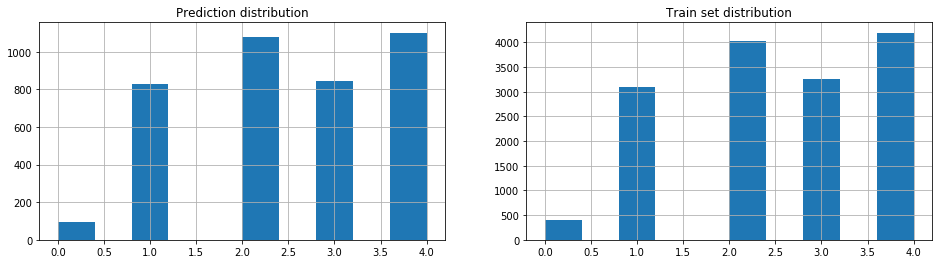

In [29]:
def run_level0(X_train, y_train, X_test):
    text_feats = PandasFeatureUnion([
        ('Original', PandasTransform(lambda x: x)),
        ('Raw description + TFIDF + SVD10', PandasPipeline([
            ('select', SelectColumns(['Description'])),
            ('preprocess', PandasTransform(lambda x: x.values.flatten().tolist())),
            ('tfidf', TfidfVectorizer(min_df=2, max_features=None, 
                strip_accents='unicode', analyzer='word', token_pattern=r'(?u)\b\w+\b', 
                 ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1)),
            ('svd', TruncatedSVD(n_components=10, random_state=1337)),
            ('df', PandasTransform(lambda x: 
                pd.DataFrame(x, columns=[f'lvl0_text_raw_desc_tfidf_svd10_{i}' for i in range(10)])))
        ])),
        ('Stemmed description + TFIDF + SVD5', PandasPipeline([
            ('select', SelectColumns(['Description'])),
            ('preprocess', PandasTransform(lambda x: x.fillna('').values.flatten().tolist())),
            ('tfidf', StemmedTfidfVectorizer(SnowballStemmer('english', ignore_stopwords=False),
                min_df=2, max_features=None, strip_accents='unicode', analyzer='word', 
                token_pattern=r'(?u)\b\w+\b', ngram_range=(1, 3), use_idf=1, smooth_idf=1, 
                sublinear_tf=1)),
            ('svd', TruncatedSVD(n_components=5, random_state=1337)),
            ('df', PandasTransform(lambda x: 
                pd.DataFrame(x, columns=[f'lvl0_text_stem_desc_tfidf_svd5_{i}' for i in range(5)])))
        ]))
    ], n_jobs=1)
    X_train = text_feats.fit_transform(X_train, y_train)
    X_test = text_feats.transform(X_test)
    
    img_feats = PandasFeatureUnion([
        ('Original', PandasTransform(lambda x: x)),
        ('NasNet + PCA5', PandasPipeline([
            ('select cols', SelectColumns(regex=r'(nasnetlarge_)')),
            ('impute', SimpleImputer(fill_value=0.)),
            ('var_thres', VarianceThreshold(0.)),
            ('pca', PCA(5, random_state=234)),
            ('df', PandasTransform(lambda x: 
                pd.DataFrame(x, columns=[f'lvl0_img_nasnet_pca5_{i}' for i in range(5)])))
        ])),
        ('NasNet + PCA400 + LR', OOFTransformer(make_pipeline(
            SelectColumns(regex=r'(nasnetlarge_)'),
            SimpleImputer(fill_value=0.),
            VarianceThreshold(0.),
            PCA(400, random_state=234),
            LinearRegression(
            )
        ), name='lvl0_img_nasnet_pca400_lr')),
        ('Xception + SVD150 + ET', OOFTransformer(make_pipeline(
            SelectColumns(regex=r'(xception_)'),
            SimpleImputer(fill_value=0.),
            VarianceThreshold(0.),
            TruncatedSVD(150, random_state=113120),
            ExtraTreesRegressor(
                n_estimators=200,
                random_state=10233
            )
        ), name='lvl0_img_xception_svd150_pca400_lr')),
    ], n_jobs=1)
    X_train = img_feats.fit_transform(X_train, y_train)
    X_test = img_feats.transform(X_test)
    
    if SUBMISSION or VERBOSE:
        display(X_train.filter(like='oof_lvl0').corr())
        display(X_test.filter(like='oof_lvl0').corr())
    if SUBMISSION:
        X_test.filter(like='oof_lvl0').to_csv('X_test_lvl0.csv', index=False)
    return X_train,X_test

def run_level1(X_train, y_train, X_test):
    normal_feats = [
        'Type', 'Age', 'Breed1', 'Breed2', 'Gender',
        'Color1', 'Color2', 'Color3', 'MaturitySize', 
        'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
        'Health', 'Quantity', 'Fee', 'State', 'VideoAmt', 'PhotoAmt',
        'Population2', '2016 GDP', 'adopted', 'MoreThanOneRescuerPet',
    ]
    lvl1 = PandasFeatureUnion([
        ('Original', PandasTransform(lambda x: x)),
        ('LGB + Non-image', OOFTransformer(make_pipeline(
            SelectColumns(normal_feats),
            LGBMRegressor(
                n_estimators=100,
                num_leaves=16,
                learning_rate=0.1,
                max_depth=5,
                colsample_bytree=0.5,
                min_split_gain=0.02,
                min_child_samples=100,
                min_child_weight=0.02,
                reg_lambda=0.01,
                random_state=SEED+374,
                objective='rmse'
                #verbose=1
            )
        ), name='lvl1_lgb_non_img')),
        ('LGB + Image and text', OOFTransformer(make_pipeline(
            SelectColumns(regex=r'(lvl0_text|lvl0_img|PhotoAmt|label_score|vertex_y)'),
            LGBMRegressor(
                n_estimators=100,
                num_leaves=16,
                learning_rate=0.1,
                max_depth=5,
                colsample_bytree=0.5,
                min_split_gain=0.02,
                min_child_samples=100,
                min_child_weight=0.02,
                reg_lambda=0.01,
                random_state=SEED+274,
                objective='rmse'
                #verbose=1
            )
        ), name='lvl1_lgb_img_text')),
        ('LGB + All features bagging', OOFTransformer(make_pipeline(
            SelectColumns(regex=r'(lvl0|label_score|vertex_y|%s)' % '|'.join(normal_feats)),
            BaggingRegressor(
                LGBMRegressor(
                    n_estimators=100,
                    num_leaves=16,
                    learning_rate=0.1,
                    max_depth=5,
                    colsample_bytree=0.5,
                    min_split_gain=0.02,
                    min_child_samples=100,
                    min_child_weight=0.02,
                    reg_lambda=0.01,
                    random_state=SEED+743,
                    objective='rmse'
                    #verbose=1
                ),
                n_estimators=20,
                max_samples=0.8,
                max_features=0.4,
                bootstrap=True,
                random_state=9843
            )
        ), name='lvl1_lgb_bagging'))
    ], n_jobs=1)
    X_train = lvl1.fit_transform(X_train, y_train)
    X_test = lvl1.transform(X_test)
    
    lvl1_rescuer_oof_mean = PandasFeatureUnion([
        ('original', PandasTransform(lambda x: x)),
        ('rescuermean', PandasTransform(lambda x: 
            grouped_feature(x, ['RescuerID'], ['oof_lvl1_lgb_bagging'], ['mean'])))
    ])
    X_train = lvl1_rescuer_oof_mean.fit_transform(X_train)
    X_test = lvl1_rescuer_oof_mean.transform(X_test)
    
    if SUBMISSION or VERBOSE:
        display(X_train.filter(regex='(oof_lvl1_|pred_)').corr())
        display(X_test.filter(regex='(oof_lvl1_|pred_)').corr())
    if SUBMISSION:
        X_test.filter(regex='(oof_lvl1_|pred_)').to_csv('X_test_lvl1.csv', index=False)
    return X_train,X_test

def run_level2(X_train, y_train, X_test):
    normal_feats = [
        'Type', 'Age', 'Breed1', 'Breed2', 'Gender',
        'Color1', 'Color2', 'Color3', 'MaturitySize', 
        'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
        'Health', 'Quantity', 'Fee', 'State', 'VideoAmt', 'PhotoAmt',
        'Population2', '2016 GDP', 'adopted', 'MoreThanOneRescuerPet',
    ]
    lvl2 = PandasFeatureUnion([
        ('Best LGB', PredictTransformer(make_pipeline(
            SelectColumns(regex=r'(lvl0|lvl1|label_score|vertex_y|%s)' % '|'.join(normal_feats)),
            LGBMRegressor(
                n_estimators=100,
                num_leaves=16,
                learning_rate=0.1,
                max_depth=5,
                colsample_bytree=0.5,
                min_split_gain=0.02,
                min_child_samples=100,
                min_child_weight=0.02,
                reg_lambda=0.01,
                random_state=SEED+74,
                objective='rmse'
                #verbose=1
            )
        ), name='lvl2_lgb')),
        ('Best CatBoost', PredictTransformer(make_pipeline(
            SelectColumns(regex=r'(lvl0|lvl1|label_score|vertex_y|%s)' % '|'.join(normal_feats)),
            CatBoostRegressor(
                n_estimators=250,
                learning_rate=0.1,
                max_depth=6,
                colsample_bylevel=0.5,
                l2_leaf_reg=1.,
                random_state=SEED+1932,
                verbose=-1
            )
        ), name='lvl2_catboost')),
        ('Best Ridge', PredictTransformer(make_pipeline(
            SelectColumns(regex=r'(oof_lvl1_lgb)'),
            DropColumns(regex=r'(RescuerID)'),
            BaggingRegressor(
                BayesianRidge(
                    normalize=False,
                    fit_intercept=True
                ),
                n_estimators=100,
                max_samples=0.8,
                max_features=1.0,
                bootstrap=True,
                random_state=93843
            )
        ), name='lvl2_ridge'))
    ], n_jobs=1)
    X_train = lvl2.fit_transform(X_train, y_train)
    X_test = lvl2.transform(X_test)
    
    if SUBMISSION or VERBOSE:
        display(X_train.filter(regex='(oof_lvl2_|pred_)').corr())
        display(X_test.filter(regex='(oof_lvl2_|pred_)').corr())
    if SUBMISSION:
        X_test.filter(regex='(oof_lvl2_|pred_)').to_csv('X_test_lvl2.csv', index=False)
    return X_train,X_test

def run_level3(X_train, y_train, X_test):
    y_pred = mode(X_test.values.T)[0].T.flatten().astype(np.int32)
    return y_pred

def run_all(X_train, y_train, X_test):
    X_train = X_train.reset_index(drop=True).copy()
    X_test = X_test.reset_index(drop=True).copy()
    
    # Common preprocessing
    if VERBOSE or SUBMISSION:
        logger.info('>> Fitting basic pipeline...')
    pl = PandasPipeline([
        ('extract_features', PandasFeatureUnion([
            ('Original features', PandasTransform(lambda x: x)),
            ('Row features', PandasTransform(row_features)),
            ('Leaky features', ExtractLeaky(X_train, X_test))
        ])),
        ('Common values', FilterCommonValues(X_train, X_test, ['Breed1','Breed2','State'])),
        ('Categoricals', ConvertType([
            'Type','Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize',
            'FurLength','Vaccinated','Dewormed','Sterilized','Health','State','adopted'], 
            'category'))
    ])
    X_train = pl.fit_transform(X_train)
    X_test = pl.transform(X_test)

    use_feats = (X_train.iloc[0:0].select_dtypes(include=['category','number'])
                 .columns.tolist() + ['RescuerID','Description'])
    X_train,X_test = X_train[use_feats],X_test[use_feats]
    
    if VERBOSE or SUBMISSION:
        logger.info('>> Level 0...')
    X_train,X_test = run_level0(X_train, y_train, X_test)
    
    if VERBOSE:
        logger.info('>> Level 1...')
    X_train,X_test = run_level1(X_train, y_train, X_test)
    
    if VERBOSE:
        logger.info('>> Level 2...')
    X_train,X_test = run_level2(X_train, y_train, X_test)
    
    if VERBOSE:
        logger.info('>> Level 3...')
    y_pred = run_level3(X_train, y_train, X_test)
    if VERBOSE or SUBMISSION:
        display(y_pred)
    return y_pred
    
USE_LB = False
    
if not SUBMISSION:
    validate(X_train, y_train, rescuer_ids)
    
if LB:
    USE_LB = True
    y_pred = run_all(X_train, y_train, X_test)
    msg = 'LB score: %.3f' % qwk(y_pred, y_test)
    logger.info(msg)
    
if SUBMISSION and not LB:
    y_pred = pd.DataFrame(run_all(X_train, y_train, X_test),
                          columns=['AdoptionSpeed'], 
                          index=test['PetID']).reset_index()
    y_pred.to_csv('submission.csv', index=False)
    
    fig,ax = plt.subplots(1,2,figsize=(16,4))
    y_pred['AdoptionSpeed'].hist(ax=ax[0])
    train['AdoptionSpeed'].hist(ax=ax[1])
    ax[0].set_title('Prediction distribution')
    ax[1].set_title('Train set distribution')
else:
    logger.info('Will not make submission without full dataset, turn LB off!')